In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, Iterator
from torchtext.data import batch as ttbatch

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import numpy as np

import os
import random
import math
import time
from tqdm import tqdm

In [0]:
# !pip install sentencepiece

In [0]:
import sentencepiece as spm

In [5]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# set random seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [0]:
import shutil
 
def copyDirectory(src, dest):
    try:
        shutil.copytree(src, dest)
    # Directories are the same
    except shutil.Error as e:
        print('Directory not copied. Error: %s' % e)
    # Any error saying that the directory doesn't exist
    except OSError as e:
        print('Directory not copied. Error: %s' % e)

In [8]:
data_dir_drive = os.path.join('gdrive', 'My Drive', 'EN-OD translation', 'data')
data_dir = 'data'
copyDirectory(data_dir_drive, data_dir)

Directory not copied. Error: [Errno 17] File exists: 'data'


In [9]:
print(os.listdir(data_dir))

['bpe_od.model', 'corpus.od', 'bpe_od.vocab', 'dev.od', 'bpe_en.vocab', 'bpe_en.model', 'corpus.en', 'dev.en', 'test.od', 'test.en']


In [10]:
!head data/corpus.od

ଭିଡିଓ ବିଜ୍ଞାପନ
ଭିଡିଓ ବିଜ୍ଞାପନ
ଗୋପନୀୟତା
ଅପଠିତ
ରିଚାର୍ଜ୍ ଦୋକାନ
ପ୍ରିସେଟ୍‌ ଅଧ୍ୟୟନ
ଡିଫଲ୍ଟ ବିଜ୍ଞାପନ
ଗୁରୁତ୍ୱପୂର୍ଣ୍ଣ ବିଭାଜନ
ବିଜ୍ଞାପନ ପରିଚାଳକ
ଅନୁକୂଳ କରାଇବା


In [11]:
for filename in sorted(os.listdir(data_dir)):
  print(f"{filename:10}: {sum(1 for line in open(os.path.join(data_dir, filename), 'r', encoding='utf-8'))}")

UnicodeDecodeError: ignored

In [12]:
spm.SentencePieceTrainer.train(f'--input={data_dir}/corpus.en --model_prefix={data_dir}/bpe_en --vocab_size=8000 --model_type=bpe')
spm.SentencePieceTrainer.train(f'--input={data_dir}/corpus.od --model_prefix={data_dir}/bpe_od --vocab_size=8000 --model_type=bpe')
sp_bpe_src = spm.SentencePieceProcessor()
sp_bpe_trg = spm.SentencePieceProcessor()
sp_bpe_src.load(f'{data_dir}/bpe_en.model')
sp_bpe_trg.load(f'{data_dir}/bpe_od.model')

True

In [13]:
print(os.listdir(data_dir))

['bpe_od.model', 'corpus.od', 'bpe_od.vocab', 'dev.od', 'bpe_en.vocab', 'bpe_en.model', 'corpus.en', 'dev.en', 'test.od', 'test.en']


In [14]:
!wc -l data/bpe_en.vocab

8000 data/bpe_en.vocab


In [15]:
!wc -l data/bpe_od.vocab

8000 data/bpe_od.vocab


In [0]:
SRC = Field(tokenize = sp_bpe_src.encode_as_pieces, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = False,
            batch_first = True)

TRG = Field(tokenize = sp_bpe_trg.encode_as_pieces,
            init_token = '<sos>', 
            eos_token = '<eos>',
            lower = False,
            batch_first = True)

In [0]:
train_data, valid_data, test_data = TranslationDataset.splits(
    path=data_dir,
    exts=('.en', '.od'),
    train='corpus',
    validation='dev',
    test='test',
    fields=(SRC, TRG)
  )

In [0]:
for dataset in [train_data, valid_data, test_data]:
  for sample in dataset:
    assert len(sample.src) <= 1000 and len(sample.trg) <=1000, 'at least one sample has > 1000 tokens'

In [0]:
SRC.build_vocab(train_data, min_freq=1)
TRG.build_vocab(train_data, min_freq=1)

In [20]:
print(f'sizes of vocab:\nen = {len(SRC.vocab)}\nod = {len(TRG.vocab)}')

sizes of vocab:
en = 8352
od = 8183


In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
# global variables
global MAX_SRC_IN_BATCH, MAX_TRG_IN_BATCH


# batch size function for MinPadIterator
def batch_size_fn(new, count, sofar):
    """Keep augmenting batch and calculate total number of tokens + padding."""
    global MAX_SRC_IN_BATCH, MAX_TRG_IN_BATCH
    if count == 1:
        MAX_SRC_IN_BATCH = 0
        MAX_TRG_IN_BATCH = 0
    MAX_SRC_IN_BATCH = max(MAX_SRC_IN_BATCH, len(new.src))
    MAX_TRG_IN_BATCH = max(MAX_TRG_IN_BATCH, len(new.trg) + 2)
    src_elements = count * MAX_SRC_IN_BATCH
    trg_elements = count * MAX_TRG_IN_BATCH
    return max(src_elements, trg_elements)


# iterator to minimize padding
class MinPadIterator(Iterator):
    def create_batches(self):

        def pool(d, random_shuffler):
            for p in ttbatch(d, self.batch_size * 100):
                p_batch = ttbatch(
                    sorted(p, key=self.sort_key),
                    self.batch_size, self.batch_size_fn)
                for b in random_shuffler(list(p_batch)):
                    yield b

        self.batches = pool(self.data(), self.random_shuffler)

In [0]:
BATCH_SIZE = 8192

# train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
#     (train_data, valid_data, test_data), 
#      batch_size = BATCH_SIZE,
#      device = device)

train_iterator = MinPadIterator(
      train_data,
      batch_size=BATCH_SIZE,
      shuffle=True,
      sort_key=lambda x: (len(x.src), len(x.trg)),
      batch_size_fn=batch_size_fn,
      device=device
  )
valid_iterator = MinPadIterator(
      valid_data,
      batch_size=BATCH_SIZE,
      shuffle=False,
      sort_key=lambda x: (len(x.src), len(x.trg)),
      batch_size_fn=batch_size_fn,
      device=device
  )
test_iterator = MinPadIterator(
      test_data,
      batch_size=BATCH_SIZE,
      shuffle=False,
      sort_key=lambda x: (len(x.src), len(x.trg)),
      batch_size_fn=batch_size_fn,
      device=device
  )

In [0]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 encoder_layer, 
                 self_attention_layer, 
                 positionwise_feedforward_layer, 
                 dropout, 
                 device):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(1000, hid_dim)
        
        self.layers = nn.ModuleList([encoder_layer(hid_dim, 
                                                   n_heads, 
                                                   pf_dim, 
                                                   self_attention_layer, 
                                                   positionwise_feedforward_layer, 
                                                   dropout, 
                                                   device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [0]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 self_attention_layer, 
                 positionwise_feedforward_layer, 
                 dropout, 
                 device):
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = self_attention_layer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = positionwise_feedforward_layer(hid_dim, 
                                                                       pf_dim, 
                                                                       dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, src len]
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward, dropout, residual and layer norm
        src = self.layer_norm(src + self.dropout(self.positionwise_feedforward(src)))
        
        #src = [batch size, src len, hid dim]
        
        return src

In [0]:
class SelfAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, seq len, seq len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
        
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, seq len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, seq len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, seq len, hid dim]
        
        x = self.fc(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x, attention

In [0]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

In [0]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 decoder_layer, 
                 self_attention_layer, 
                 positionwise_feedforward_layer, 
                 dropout, 
                 device):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(1000, hid_dim)
        
        self.layers = nn.ModuleList([decoder_layer(hid_dim, 
                                                   n_heads, 
                                                   pf_dim, 
                                                   self_attention_layer, 
                                                   positionwise_feedforward_layer, 
                                                   dropout, 
                                                   device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [0]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 self_attention_layer, 
                 positionwise_feedforward_layer, 
                 dropout, 
                 device):
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = self_attention_layer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = self_attention_layer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = positionwise_feedforward_layer(hid_dim, 
                                                                       pf_dim, 
                                                                       dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward, dropout, residual and layer norm
        trg = self.layer_norm(trg + self.dropout(self.positionwise_feedforward(trg)))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

In [0]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 trg_sos_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.trg_sos_idx = trg_sos_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(3)
        
        #trg_pad_mask = [batch size, 1, trg len, 1]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention


In [0]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 128
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 256
DEC_PF_DIM = 256
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              EncoderLayer, 
              SelfAttentionLayer, 
              PositionwiseFeedforwardLayer, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DecoderLayer, 
              SelfAttentionLayer, 
              PositionwiseFeedforwardLayer, 
              DEC_DROPOUT, 
              device)

In [0]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
TRG_SOS_IDX = TRG.vocab.stoi[TRG.init_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, TRG_SOS_IDX, device).to(device)

In [33]:
model

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(8352, 128)
    (pos_embedding): Embedding(1000, 128)
    (layers): ModuleList(
      (0): EncoderLayer(
        (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (self_attention): SelfAttentionLayer(
          (fc_q): Linear(in_features=128, out_features=128, bias=True)
          (fc_k): Linear(in_features=128, out_features=128, bias=True)
          (fc_v): Linear(in_features=128, out_features=128, bias=True)
          (fc): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=128, out_features=256, bias=True)
          (fc_2): Linear(in_features=256, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): EncoderLayer(
        (layer_nor

In [34]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,419,575 trainable parameters


In [0]:
# xavier initialization

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [0]:
model.apply(initialize_weights);

In [0]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [0]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [0]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0

    tqdm_meter = tqdm(iterator, unit=' batches', desc=f'[EPOCH {epoch}/{N_EPOCHS}]', leave=False, total=0)
    
    for i, batch in enumerate(tqdm_meter):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()

        # update tqdm meter
        tqdm_meter.set_postfix(loss=f'{loss.item():0.4f}', ppl=f'{math.exp(loss.item()):0.2f}')
        tqdm_meter.update()

    return epoch_loss / (i + 1)

In [0]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(tqdm(iterator, unit=' batches', leave=False, total=0)):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / (i + 1)

In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [42]:
N_EPOCHS = 100
CLIP = 1

best_valid_loss = float('inf')
train_losses, val_losses = [], []


for epoch in range(1, N_EPOCHS + 1):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        print('\n\t--Found new best val loss')
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')
    
    print(f'\nEpoch: {epoch:02} (^_^) Time: {epoch_mins}m {epoch_secs}s', end='')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}', end='')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

[EPOCH 2/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 01 (^_^) Time: 0m 43s	Train Loss: 7.696 | Train PPL: 2200.467	 Val. Loss: 7.216 |  Val. PPL: 1360.833


[EPOCH 3/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 02 (^_^) Time: 0m 42s	Train Loss: 6.651 | Train PPL: 773.763	 Val. Loss: 6.383 |  Val. PPL: 591.584


[EPOCH 4/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 03 (^_^) Time: 0m 43s	Train Loss: 6.019 | Train PPL: 411.247	 Val. Loss: 5.936 |  Val. PPL: 378.262


[EPOCH 5/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 04 (^_^) Time: 0m 42s	Train Loss: 5.576 | Train PPL: 264.047	 Val. Loss: 5.592 |  Val. PPL: 268.288


[EPOCH 6/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 05 (^_^) Time: 0m 42s	Train Loss: 5.224 | Train PPL: 185.748	 Val. Loss: 5.331 |  Val. PPL: 206.738


[EPOCH 7/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 06 (^_^) Time: 0m 42s	Train Loss: 4.942 | Train PPL: 140.065	 Val. Loss: 4.964 |  Val. PPL: 143.220


[EPOCH 8/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 07 (^_^) Time: 0m 43s	Train Loss: 4.685 | Train PPL: 108.322	 Val. Loss: 4.599 |  Val. PPL:  99.341


[EPOCH 9/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 08 (^_^) Time: 0m 43s	Train Loss: 4.467 | Train PPL:  87.133	 Val. Loss: 4.287 |  Val. PPL:  72.758


[EPOCH 10/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 09 (^_^) Time: 0m 43s	Train Loss: 4.279 | Train PPL:  72.163	 Val. Loss: 4.033 |  Val. PPL:  56.436


[EPOCH 11/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 10 (^_^) Time: 0m 43s	Train Loss: 4.104 | Train PPL:  60.569	 Val. Loss: 3.718 |  Val. PPL:  41.173


[EPOCH 12/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 11 (^_^) Time: 0m 43s	Train Loss: 3.946 | Train PPL:  51.723	 Val. Loss: 3.490 |  Val. PPL:  32.774


[EPOCH 13/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 12 (^_^) Time: 0m 43s	Train Loss: 3.797 | Train PPL:  44.560	 Val. Loss: 3.249 |  Val. PPL:  25.758


[EPOCH 14/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 13 (^_^) Time: 0m 43s	Train Loss: 3.669 | Train PPL:  39.206	 Val. Loss: 3.040 |  Val. PPL:  20.898


[EPOCH 15/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 14 (^_^) Time: 0m 43s	Train Loss: 3.545 | Train PPL:  34.645	 Val. Loss: 2.905 |  Val. PPL:  18.269


[EPOCH 16/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 15 (^_^) Time: 0m 43s	Train Loss: 3.427 | Train PPL:  30.795	 Val. Loss: 2.786 |  Val. PPL:  16.209


[EPOCH 17/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 16 (^_^) Time: 0m 43s	Train Loss: 3.320 | Train PPL:  27.650	 Val. Loss: 2.522 |  Val. PPL:  12.451


[EPOCH 18/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 17 (^_^) Time: 0m 43s	Train Loss: 3.219 | Train PPL:  25.013	 Val. Loss: 2.433 |  Val. PPL:  11.388


[EPOCH 19/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 18 (^_^) Time: 0m 42s	Train Loss: 3.128 | Train PPL:  22.826	 Val. Loss: 2.265 |  Val. PPL:   9.635


[EPOCH 20/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 19 (^_^) Time: 0m 43s	Train Loss: 3.041 | Train PPL:  20.921	 Val. Loss: 2.124 |  Val. PPL:   8.361


[EPOCH 21/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 20 (^_^) Time: 0m 43s	Train Loss: 2.955 | Train PPL:  19.193	 Val. Loss: 1.974 |  Val. PPL:   7.198


[EPOCH 22/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 21 (^_^) Time: 0m 43s	Train Loss: 2.880 | Train PPL:  17.812	 Val. Loss: 1.897 |  Val. PPL:   6.665


[EPOCH 23/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 22 (^_^) Time: 0m 43s	Train Loss: 2.803 | Train PPL:  16.487	 Val. Loss: 1.783 |  Val. PPL:   5.948


[EPOCH 24/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 23 (^_^) Time: 0m 43s	Train Loss: 2.732 | Train PPL:  15.360	 Val. Loss: 1.687 |  Val. PPL:   5.406


[EPOCH 25/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 24 (^_^) Time: 0m 43s	Train Loss: 2.670 | Train PPL:  14.445	 Val. Loss: 1.628 |  Val. PPL:   5.092


[EPOCH 26/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 25 (^_^) Time: 0m 43s	Train Loss: 2.606 | Train PPL:  13.540	 Val. Loss: 1.542 |  Val. PPL:   4.674


[EPOCH 27/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 26 (^_^) Time: 0m 43s	Train Loss: 2.547 | Train PPL:  12.764	 Val. Loss: 1.459 |  Val. PPL:   4.302


[EPOCH 28/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 27 (^_^) Time: 0m 43s	Train Loss: 2.493 | Train PPL:  12.100	 Val. Loss: 1.372 |  Val. PPL:   3.945


[EPOCH 29/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 28 (^_^) Time: 0m 43s	Train Loss: 2.438 | Train PPL:  11.452	 Val. Loss: 1.324 |  Val. PPL:   3.759


[EPOCH 30/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 29 (^_^) Time: 0m 43s	Train Loss: 2.396 | Train PPL:  10.978	 Val. Loss: 1.263 |  Val. PPL:   3.535


[EPOCH 31/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 30 (^_^) Time: 0m 43s	Train Loss: 2.341 | Train PPL:  10.388	 Val. Loss: 1.185 |  Val. PPL:   3.270


[EPOCH 32/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 31 (^_^) Time: 0m 43s	Train Loss: 2.294 | Train PPL:   9.919	 Val. Loss: 1.135 |  Val. PPL:   3.111


[EPOCH 33/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 32 (^_^) Time: 0m 43s	Train Loss: 2.251 | Train PPL:   9.496	 Val. Loss: 1.106 |  Val. PPL:   3.023


[EPOCH 34/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 33 (^_^) Time: 0m 43s	Train Loss: 2.211 | Train PPL:   9.125	 Val. Loss: 1.046 |  Val. PPL:   2.847


[EPOCH 35/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 34 (^_^) Time: 0m 43s	Train Loss: 2.169 | Train PPL:   8.750	 Val. Loss: 0.976 |  Val. PPL:   2.653


[EPOCH 36/100]: 0 batches [00:00, ? batches/s]


Epoch: 35 (^_^) Time: 0m 43s	Train Loss: 2.133 | Train PPL:   8.440	 Val. Loss: 0.984 |  Val. PPL:   2.676


[EPOCH 37/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 36 (^_^) Time: 0m 43s	Train Loss: 2.094 | Train PPL:   8.119	 Val. Loss: 0.900 |  Val. PPL:   2.459


[EPOCH 38/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 37 (^_^) Time: 0m 43s	Train Loss: 2.063 | Train PPL:   7.866	 Val. Loss: 0.852 |  Val. PPL:   2.345


[EPOCH 39/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 38 (^_^) Time: 0m 43s	Train Loss: 2.028 | Train PPL:   7.602	 Val. Loss: 0.835 |  Val. PPL:   2.305


[EPOCH 40/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 39 (^_^) Time: 0m 43s	Train Loss: 1.994 | Train PPL:   7.343	 Val. Loss: 0.799 |  Val. PPL:   2.224


[EPOCH 41/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 40 (^_^) Time: 0m 43s	Train Loss: 1.970 | Train PPL:   7.174	 Val. Loss: 0.795 |  Val. PPL:   2.214


[EPOCH 42/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 41 (^_^) Time: 0m 43s	Train Loss: 1.936 | Train PPL:   6.928	 Val. Loss: 0.752 |  Val. PPL:   2.122


[EPOCH 43/100]: 0 batches [00:00, ? batches/s]


Epoch: 42 (^_^) Time: 0m 43s	Train Loss: 1.910 | Train PPL:   6.754	 Val. Loss: 0.760 |  Val. PPL:   2.138


[EPOCH 44/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 43 (^_^) Time: 0m 43s	Train Loss: 1.885 | Train PPL:   6.589	 Val. Loss: 0.725 |  Val. PPL:   2.064


[EPOCH 45/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 44 (^_^) Time: 0m 43s	Train Loss: 1.856 | Train PPL:   6.397	 Val. Loss: 0.712 |  Val. PPL:   2.038


[EPOCH 46/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 45 (^_^) Time: 0m 43s	Train Loss: 1.830 | Train PPL:   6.235	 Val. Loss: 0.686 |  Val. PPL:   1.987


[EPOCH 47/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 46 (^_^) Time: 0m 43s	Train Loss: 1.803 | Train PPL:   6.069	 Val. Loss: 0.686 |  Val. PPL:   1.986


[EPOCH 48/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 47 (^_^) Time: 0m 43s	Train Loss: 1.786 | Train PPL:   5.966	 Val. Loss: 0.630 |  Val. PPL:   1.877


[EPOCH 49/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 48 (^_^) Time: 0m 43s	Train Loss: 1.758 | Train PPL:   5.802	 Val. Loss: 0.618 |  Val. PPL:   1.856


[EPOCH 50/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 49 (^_^) Time: 0m 43s	Train Loss: 1.739 | Train PPL:   5.690	 Val. Loss: 0.607 |  Val. PPL:   1.836


[EPOCH 51/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 50 (^_^) Time: 0m 43s	Train Loss: 1.718 | Train PPL:   5.573	 Val. Loss: 0.569 |  Val. PPL:   1.766


[EPOCH 52/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 51 (^_^) Time: 0m 43s	Train Loss: 1.696 | Train PPL:   5.452	 Val. Loss: 0.560 |  Val. PPL:   1.751


[EPOCH 53/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 52 (^_^) Time: 0m 43s	Train Loss: 1.680 | Train PPL:   5.367	 Val. Loss: 0.535 |  Val. PPL:   1.708


[EPOCH 54/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 53 (^_^) Time: 0m 43s	Train Loss: 1.658 | Train PPL:   5.251	 Val. Loss: 0.524 |  Val. PPL:   1.688


[EPOCH 55/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 54 (^_^) Time: 0m 43s	Train Loss: 1.643 | Train PPL:   5.170	 Val. Loss: 0.497 |  Val. PPL:   1.643


[EPOCH 56/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 55 (^_^) Time: 0m 43s	Train Loss: 1.622 | Train PPL:   5.062	 Val. Loss: 0.472 |  Val. PPL:   1.603


[EPOCH 57/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 56 (^_^) Time: 0m 43s	Train Loss: 1.607 | Train PPL:   4.987	 Val. Loss: 0.468 |  Val. PPL:   1.596


[EPOCH 58/100]: 0 batches [00:00, ? batches/s]


Epoch: 57 (^_^) Time: 0m 43s	Train Loss: 1.585 | Train PPL:   4.880	 Val. Loss: 0.468 |  Val. PPL:   1.597


[EPOCH 59/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 58 (^_^) Time: 0m 43s	Train Loss: 1.575 | Train PPL:   4.829	 Val. Loss: 0.467 |  Val. PPL:   1.595


[EPOCH 60/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 59 (^_^) Time: 0m 43s	Train Loss: 1.557 | Train PPL:   4.743	 Val. Loss: 0.429 |  Val. PPL:   1.536


[EPOCH 61/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 60 (^_^) Time: 0m 43s	Train Loss: 1.540 | Train PPL:   4.667	 Val. Loss: 0.414 |  Val. PPL:   1.513


[EPOCH 62/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 61 (^_^) Time: 0m 43s	Train Loss: 1.527 | Train PPL:   4.605	 Val. Loss: 0.407 |  Val. PPL:   1.503


[EPOCH 63/100]: 0 batches [00:00, ? batches/s]


Epoch: 62 (^_^) Time: 0m 43s	Train Loss: 1.519 | Train PPL:   4.568	 Val. Loss: 0.422 |  Val. PPL:   1.526


[EPOCH 64/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 63 (^_^) Time: 0m 43s	Train Loss: 1.499 | Train PPL:   4.479	 Val. Loss: 0.397 |  Val. PPL:   1.487


[EPOCH 65/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 64 (^_^) Time: 0m 43s	Train Loss: 1.490 | Train PPL:   4.439	 Val. Loss: 0.375 |  Val. PPL:   1.456


[EPOCH 66/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 65 (^_^) Time: 0m 43s	Train Loss: 1.477 | Train PPL:   4.379	 Val. Loss: 0.372 |  Val. PPL:   1.451


[EPOCH 67/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 66 (^_^) Time: 0m 43s	Train Loss: 1.462 | Train PPL:   4.315	 Val. Loss: 0.368 |  Val. PPL:   1.445


[EPOCH 68/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 67 (^_^) Time: 0m 43s	Train Loss: 1.452 | Train PPL:   4.272	 Val. Loss: 0.366 |  Val. PPL:   1.442


[EPOCH 69/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 68 (^_^) Time: 0m 42s	Train Loss: 1.438 | Train PPL:   4.211	 Val. Loss: 0.356 |  Val. PPL:   1.427


[EPOCH 70/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 69 (^_^) Time: 0m 42s	Train Loss: 1.429 | Train PPL:   4.176	 Val. Loss: 0.348 |  Val. PPL:   1.416


[EPOCH 71/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 70 (^_^) Time: 0m 42s	Train Loss: 1.419 | Train PPL:   4.135	 Val. Loss: 0.346 |  Val. PPL:   1.414


[EPOCH 72/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 71 (^_^) Time: 0m 43s	Train Loss: 1.404 | Train PPL:   4.072	 Val. Loss: 0.341 |  Val. PPL:   1.406


[EPOCH 73/100]: 0 batches [00:00, ? batches/s]


Epoch: 72 (^_^) Time: 0m 43s	Train Loss: 1.393 | Train PPL:   4.026	 Val. Loss: 0.351 |  Val. PPL:   1.420


[EPOCH 74/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 73 (^_^) Time: 0m 43s	Train Loss: 1.385 | Train PPL:   3.994	 Val. Loss: 0.318 |  Val. PPL:   1.374


[EPOCH 75/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 74 (^_^) Time: 0m 43s	Train Loss: 1.376 | Train PPL:   3.959	 Val. Loss: 0.311 |  Val. PPL:   1.365


[EPOCH 76/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 75 (^_^) Time: 0m 43s	Train Loss: 1.369 | Train PPL:   3.929	 Val. Loss: 0.308 |  Val. PPL:   1.361


[EPOCH 77/100]: 0 batches [00:00, ? batches/s]


Epoch: 76 (^_^) Time: 0m 43s	Train Loss: 1.358 | Train PPL:   3.889	 Val. Loss: 0.324 |  Val. PPL:   1.383


[EPOCH 78/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 77 (^_^) Time: 0m 43s	Train Loss: 1.347 | Train PPL:   3.844	 Val. Loss: 0.303 |  Val. PPL:   1.353


[EPOCH 79/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 78 (^_^) Time: 0m 43s	Train Loss: 1.336 | Train PPL:   3.802	 Val. Loss: 0.281 |  Val. PPL:   1.325


[EPOCH 80/100]: 0 batches [00:00, ? batches/s]


Epoch: 79 (^_^) Time: 0m 43s	Train Loss: 1.327 | Train PPL:   3.769	 Val. Loss: 0.281 |  Val. PPL:   1.325


[EPOCH 81/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 80 (^_^) Time: 0m 43s	Train Loss: 1.322 | Train PPL:   3.750	 Val. Loss: 0.264 |  Val. PPL:   1.302


[EPOCH 82/100]: 0 batches [00:00, ? batches/s]


Epoch: 81 (^_^) Time: 0m 43s	Train Loss: 1.305 | Train PPL:   3.689	 Val. Loss: 0.269 |  Val. PPL:   1.309


[EPOCH 83/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 82 (^_^) Time: 0m 43s	Train Loss: 1.300 | Train PPL:   3.668	 Val. Loss: 0.264 |  Val. PPL:   1.302


[EPOCH 84/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 83 (^_^) Time: 0m 43s	Train Loss: 1.291 | Train PPL:   3.637	 Val. Loss: 0.250 |  Val. PPL:   1.284


[EPOCH 85/100]: 0 batches [00:00, ? batches/s]


Epoch: 84 (^_^) Time: 0m 43s	Train Loss: 1.285 | Train PPL:   3.615	 Val. Loss: 0.317 |  Val. PPL:   1.373


[EPOCH 86/100]: 0 batches [00:00, ? batches/s]


Epoch: 85 (^_^) Time: 0m 43s	Train Loss: 1.280 | Train PPL:   3.597	 Val. Loss: 0.275 |  Val. PPL:   1.317


[EPOCH 87/100]: 0 batches [00:00, ? batches/s]


Epoch: 86 (^_^) Time: 0m 43s	Train Loss: 1.272 | Train PPL:   3.569	 Val. Loss: 0.264 |  Val. PPL:   1.302


[EPOCH 88/100]: 0 batches [00:00, ? batches/s]


Epoch: 87 (^_^) Time: 0m 43s	Train Loss: 1.262 | Train PPL:   3.534	 Val. Loss: 0.261 |  Val. PPL:   1.298


[EPOCH 89/100]: 0 batches [00:00, ? batches/s]


Epoch: 88 (^_^) Time: 0m 43s	Train Loss: 1.254 | Train PPL:   3.505	 Val. Loss: 0.260 |  Val. PPL:   1.297


[EPOCH 90/100]: 0 batches [00:00, ? batches/s]


Epoch: 89 (^_^) Time: 0m 43s	Train Loss: 1.252 | Train PPL:   3.496	 Val. Loss: 0.258 |  Val. PPL:   1.294


[EPOCH 91/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 90 (^_^) Time: 0m 43s	Train Loss: 1.240 | Train PPL:   3.456	 Val. Loss: 0.237 |  Val. PPL:   1.268


[EPOCH 92/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 91 (^_^) Time: 0m 43s	Train Loss: 1.234 | Train PPL:   3.437	 Val. Loss: 0.233 |  Val. PPL:   1.263


[EPOCH 93/100]: 0 batches [00:00, ? batches/s]


Epoch: 92 (^_^) Time: 0m 43s	Train Loss: 1.227 | Train PPL:   3.411	 Val. Loss: 0.252 |  Val. PPL:   1.287


[EPOCH 94/100]: 0 batches [00:00, ? batches/s]


Epoch: 93 (^_^) Time: 0m 43s	Train Loss: 1.226 | Train PPL:   3.407	 Val. Loss: 0.236 |  Val. PPL:   1.266


[EPOCH 95/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 94 (^_^) Time: 0m 43s	Train Loss: 1.218 | Train PPL:   3.381	 Val. Loss: 0.225 |  Val. PPL:   1.253


[EPOCH 96/100]: 0 batches [00:00, ? batches/s]


Epoch: 95 (^_^) Time: 0m 43s	Train Loss: 1.208 | Train PPL:   3.348	 Val. Loss: 0.239 |  Val. PPL:   1.270


[EPOCH 97/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 96 (^_^) Time: 0m 43s	Train Loss: 1.202 | Train PPL:   3.328	 Val. Loss: 0.225 |  Val. PPL:   1.252


[EPOCH 98/100]: 0 batches [00:00, ? batches/s]


Epoch: 97 (^_^) Time: 0m 43s	Train Loss: 1.196 | Train PPL:   3.306	 Val. Loss: 0.252 |  Val. PPL:   1.287


[EPOCH 99/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 98 (^_^) Time: 0m 42s	Train Loss: 1.197 | Train PPL:   3.311	 Val. Loss: 0.211 |  Val. PPL:   1.235


[EPOCH 100/100]: 0 batches [00:00, ? batches/s]


	--Found new best val loss

Epoch: 99 (^_^) Time: 0m 43s	Train Loss: 1.183 | Train PPL:   3.265	 Val. Loss: 0.206 |  Val. PPL:   1.229



	--Found new best val loss

Epoch: 100 (^_^) Time: 0m 43s	Train Loss: 1.179 | Train PPL:   3.251	 Val. Loss: 0.202 |  Val. PPL:   1.224


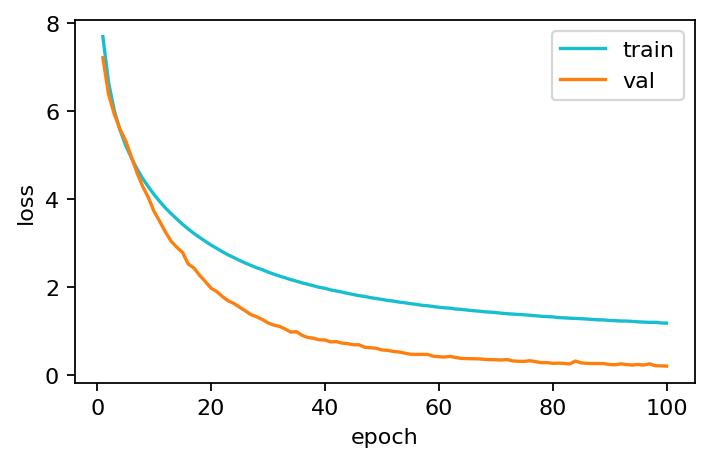

In [43]:
# plot losses
plt.figure(figsize=(5, 3), dpi=160)
plt.plot(range(1, N_EPOCHS + 1), train_losses, color='tab:cyan', label='train')
plt.plot(range(1, N_EPOCHS + 1), val_losses, color='tab:orange', label='val')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [44]:
model.load_state_dict(torch.load('model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 0.202 | Test PPL:   1.224 |


In [0]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()

    tokens = [src_field.init_token] + sentence + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [107]:
!ls gdrive/My\ Drive/EN-OD\ translation

data  en-od  od-en  OR51_Ananta.ttf


In [0]:
from matplotlib import font_manager as fm
fpath = os.path.join('gdrive', 'My Drive', 'EN-OD translation', 'OR51_Ananta.ttf')
prop = fm.FontProperties(fname=fpath)

In [0]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(1, n_heads+1):
        
        ax = fig.add_subplot(n_rows, n_cols,i)
        
        _attention = attention.squeeze(0)[i-1].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='Oranges')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+sentence+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation, fontproperties=prop)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [110]:
example_idx = 11

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['▁R', 'ights', '▁Man', 'ager', '▁for', '▁Music']
trg = ['▁ସଙ୍ଗୀତ', '▁ପାଇଁ', '▁Right', 's', '▁Man', 'ag', 'er']


In [111]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['▁ସଙ୍ଗୀତ', '▁ପାଇଁ', '▁Right', 's', '▁Man', 'ag', 'er', '<eos>']


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


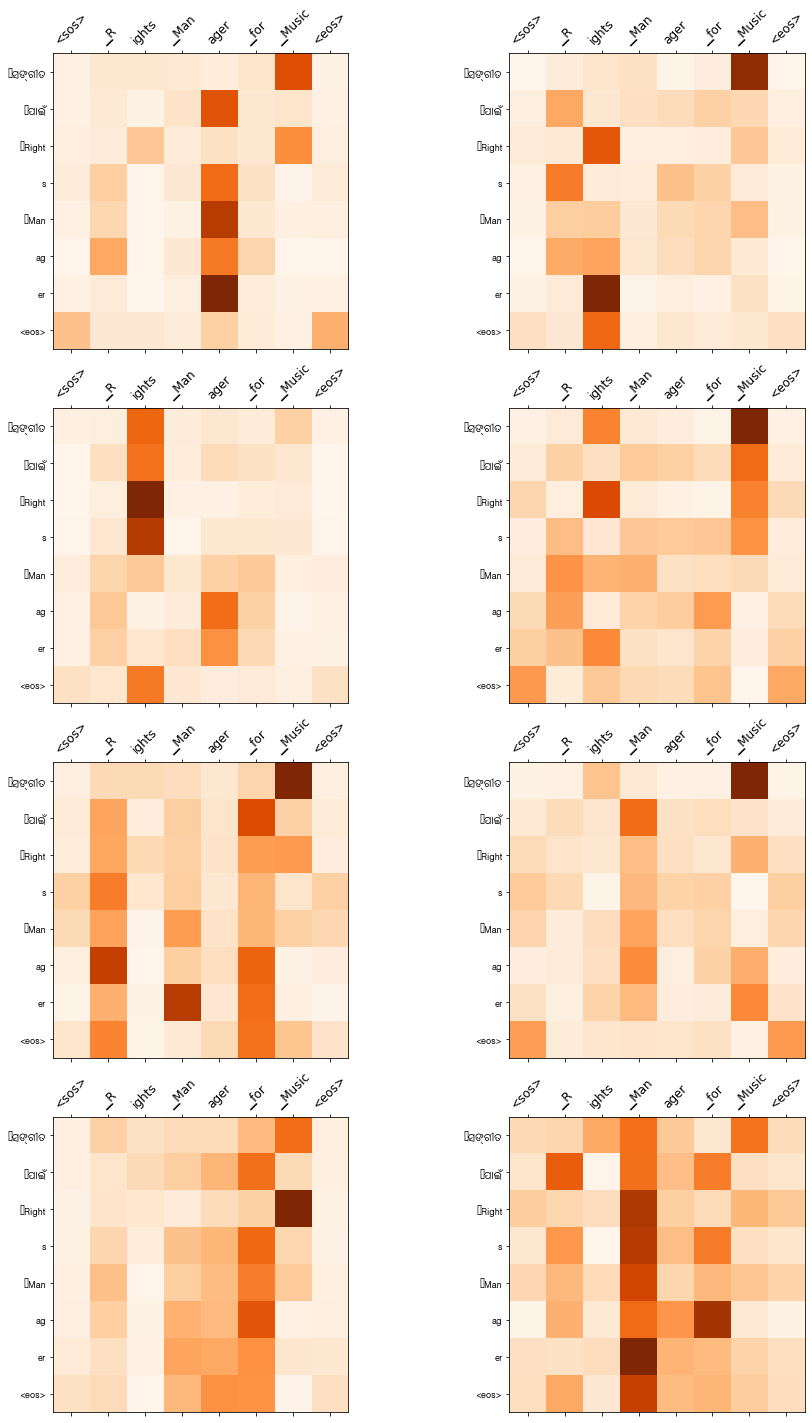

In [112]:
display_attention(src, translation, attention)

In [0]:
import collections

def ngrams_iterator(token_list, ngrams):
    """Return an iterator that yields the given tokens and their ngrams.
    Arguments:
        token_list: A list of tokens
        ngrams: the number of ngrams.
    Examples:
        >>> token_list = ['here', 'we', 'are']
        >>> list(ngrams_iterator(token_list, 2))
        >>> ['here', 'here we', 'we', 'we are', 'are']
    """

    def _get_ngrams(n):
        return zip(*[token_list[i:] for i in range(n)])

    for x in token_list:
        yield x
    for n in range(2, ngrams + 1):
        for x in _get_ngrams(n):
            yield ' '.join(x)


def _compute_ngram_counter(tokens, max_n):
    """ Create a Counter with a count of unique n-grams in the tokens list
    Arguments:
        tokens: a list of tokens (typically a string split on whitespaces)
        max_n: the maximum order of n-gram wanted
    Outputs:
        output: a collections.Counter object with the unique n-grams and their
            associated count
    Examples:
        >>> from torchtext.data.metrics import _compute_ngram_counter
        >>> tokens = ['me', 'me', 'you']
        >>> _compute_ngram_counter(tokens, 2)
            Counter({('me',): 2,
             ('you',): 1,
             ('me', 'me'): 1,
             ('me', 'you'): 1,
             ('me', 'me', 'you'): 1})
    """
    assert max_n > 0
    ngrams_counter = collections.Counter(tuple(x.split(' '))
                                         for x in ngrams_iterator(tokens, max_n))

    return ngrams_counter


def bleu_score(candidate_corpus, references_corpus, max_n=4, weights=[0.25] * 4):
    """Computes the BLEU score between a candidate translation corpus and a references
    translation corpus. Based on https://www.aclweb.org/anthology/P02-1040.pdf
    Arguments:
        candidate_corpus: an iterable of candidate translations. Each translation is an
            iterable of tokens
        references_corpus: an iterable of iterables of reference translations. Each
            translation is an iterable of tokens
        max_n: the maximum n-gram we want to use. E.g. if max_n=3, we will use unigrams,
            bigrams and trigrams
        weights: a list of weights used for each n-gram category (uniform by default)
    Examples:
        >>> from torchtext.data.metrics import bleu_score
        >>> candidate_corpus = [['I', 'ate', 'the', 'apple'], ['I', 'did']]
        >>> references_corpus = [[['I', 'ate', 'it'], ['I', 'ate', 'apples']],
                [['I', 'did']]]
        >>> bleu_score(candidate_corpus, references_corpus)
            0.7598356856515925
    """

    assert max_n == len(weights), 'Length of the "weights" list has be equal to max_n'
    assert len(candidate_corpus) == len(references_corpus),\
        'The length of candidate and reference corpus should be the same'

    clipped_counts = torch.zeros(max_n)
    total_counts = torch.zeros(max_n)
    weights = torch.tensor(weights)

    candidate_len = 0.0
    refs_len = 0.0

    for (candidate, refs) in zip(candidate_corpus, references_corpus):
        candidate_len += len(candidate)

        # Get the length of the reference that's closest in length to the candidate
        refs_len_list = [float(len(ref)) for ref in refs]
        refs_len += min(refs_len_list, key=lambda x: abs(len(candidate) - x))

        reference_counters = _compute_ngram_counter(refs[0], max_n)
        for ref in refs[1:]:
            reference_counters = reference_counters | _compute_ngram_counter(ref, max_n)

        candidate_counter = _compute_ngram_counter(candidate, max_n)

        clipped_counter = candidate_counter & reference_counters

        for ngram in clipped_counter:
            clipped_counts[len(ngram) - 1] += clipped_counter[ngram]

        for ngram in candidate_counter:  # TODO: no need to loop through the whole counter
            total_counts[len(ngram) - 1] += candidate_counter[ngram]

    if min(clipped_counts) == 0:
        return 0.0
    else:
        pn = clipped_counts / total_counts
        log_pn = weights * torch.log(pn)
        score = torch.exp(sum(log_pn))

        bp = math.exp(min(1 - refs_len / candidate_len, 0))

        return bp * score.item()

In [0]:
def translate_sentences(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in tqdm(data, unit=' samples'):
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        trgs.append([trg])
        pred_trgs.append(pred_trg)
        
    return trgs, pred_trgs

In [64]:
labels, preds = translate_sentences(test_data, SRC, TRG, model, device)

100%|██████████| 3922/3922 [02:51<00:00, 22.93 samples/s]


In [0]:
# !pip install sacrebleu
import sacrebleu

In [0]:
outs = preds
refs = labels
outs_str = list(map(lambda l: sp_bpe_trg.decode_pieces(l), outs))
refs_str = [list(map(lambda l: sp_bpe_trg.decode_pieces(l[0]), refs))]

In [70]:
print(f'BLEU score = {bleu_score(outs, refs)*100:.2f}')
print(f'SACREBLEU score = {sacrebleu.corpus_bleu(outs_str, refs_str, force=False).score:.2f}')

BLEU score = 83.58
SACREBLEU score = 81.29
